In [44]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from numpy import linalg as LA

from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

In [45]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

In [46]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test = x_test[0:100]
y_test = y_test[0:100]

# Train and evaluate a baseline classifier

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']);

In [48]:
model.fit(x_train, y_train, epochs=3);

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 49us/sample - loss: 0.3000 - accuracy: 0.9124
Epoch 2/3
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1452 - accuracy: 0.9565
Epoch 3/3
60000/60000 [==============================] - 3s 48us/sample - loss: 0.1081 - accuracy: 0.9671


In [49]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 529us/sample - loss: 0.0218 - accuracy: 1.0000
Accuracy on test data: 100.00%


In [50]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Fast Gradient Sign Method attack on baseline classifier

In [51]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv_fgsm = attack_fgsm.generate(x_test)

In [52]:
loss_test, accuracy_test = model.evaluate(x_test_adv_fgsm, y_test)
perturbation = np.mean(np.abs((x_test_adv_fgsm - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 50us/sample - loss: 15.2518 - accuracy: 0.0000e+00
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


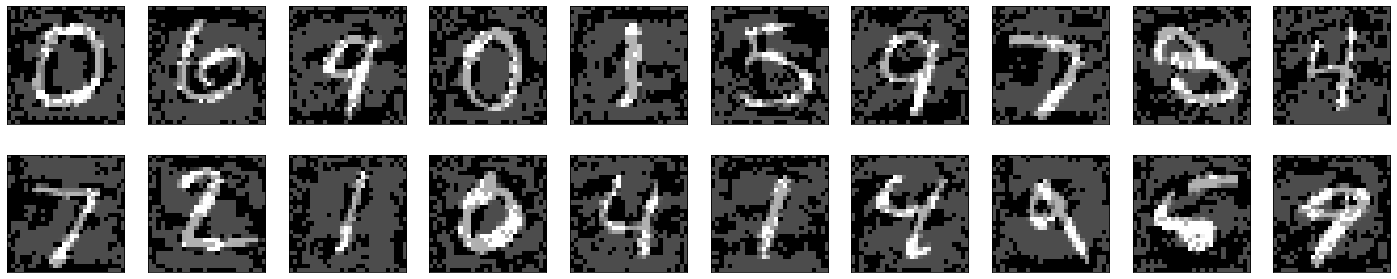

In [53]:
fig    = plt.figure(figsize=(50, 10))
cols   = 20
images_fgsm = list(x_test_adv_fgsm[:cols])

for i in range(0, len(images_fgsm)):
    ax = fig.add_subplot((i/10)+1, cols, (i%10)+1)
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images_fgsm[i], cmap='gray')

plt.show()

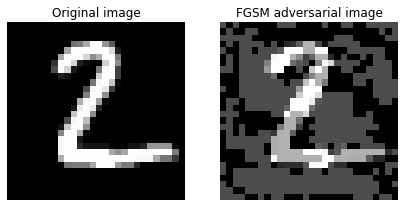

In [54]:
original_img = x_test[1]
adv_image_fgsm = images_fgsm[1]

fig    = plt.figure(figsize=(7, 5))

fig.add_subplot(1,2,1)
plt.title("Original image")
plt.imshow(original_img, cmap='gray')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.title("FGSM adversarial image")
plt.imshow(adv_image_fgsm, cmap='gray')
plt.axis('off')

plt.show()

### L0, L1, L2 between original image and FGSM adversarial image

In [55]:
ext_fgsm = original_img-adv_image_fgsm

L0_dist = sum(sum(ext_fgsm != 0)) / np.size(ext_cw) 
print("Frobenius norm (L0)    : {:4.2f}%".format(L0_dist * 100))

L2_dist = LA.norm(ext_fgsm)
print("Frobenius norm (L2)    : ", L2_dist)

L_inf_dist = LA.norm(ext_fgsm, np.inf)
print("Frobenius norm (L_inf) : ", L_inf_dist)

Frobenius norm (L0)    : 67.22%
Frobenius norm (L2)    :  6.560094161936641
Frobenius norm (L_inf) :  7.500000298023224


# Carlini&Wagner Infinity-norm attack on baseline classifier

In [56]:
attack_cw = CarliniLInfMethod(classifier=classifier, eps=0.3, max_iter=100, learning_rate=0.01)
x_test_adv_cw = attack_cw.generate(x_test)

C&W L_inf: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


In [57]:
loss_test, accuracy_test = model.evaluate(x_test_adv_cw, y_test)
perturbation = np.mean(np.abs((x_test_adv_cw - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 80us/sample - loss: 2.3817 - accuracy: 0.0900
Accuracy on adversarial test data: 9.00%
Average perturbation: 0.04


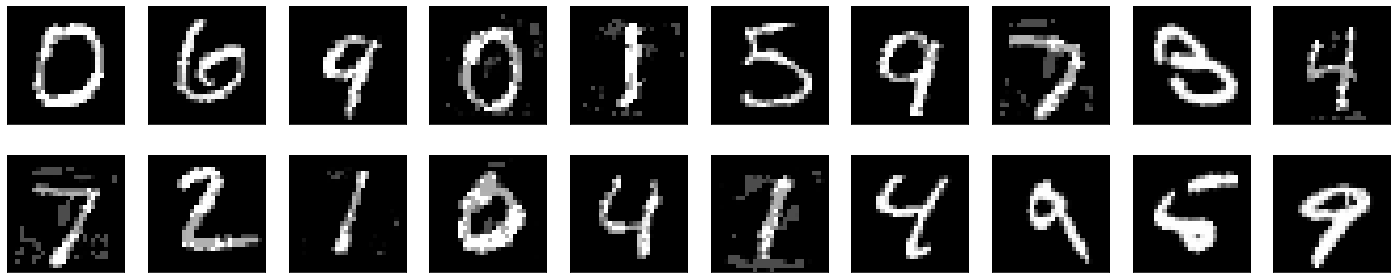

In [58]:
fig    = plt.figure(figsize=(50, 10))
cols   = 20
images_cw = list(x_test_adv_cw[:cols])

for i in range(0, len(images_cw)):
    ax = fig.add_subplot((i/10)+1, cols, (i%10)+1)
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images_cw[i], cmap='gray')

plt.show()

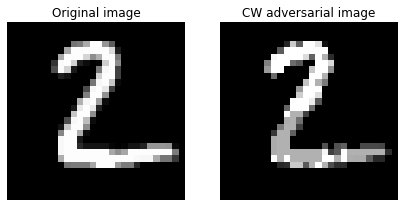

In [59]:
original_img = x_test[1]
adv_image_cw = images_cw[1]

fig    = plt.figure(figsize=(7, 5))

fig.add_subplot(1,2,1)
plt.title("Original image")
plt.imshow(original_img, cmap='gray')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.title("CW adversarial image")
plt.imshow(adv_image_cw, cmap='gray')
plt.axis('off')

plt.show()

### L0, L1, L2 between original image and CW adversarial image

In [60]:
ext_cw = original_img-adv_image_cw

L0_dist = (sum(sum(ext_cw != 0))) / np.size(ext_cw)
print("Frobenius norm (L0)    : {:4.2f}%".format(L0_dist * 100))

L2_dist = LA.norm(ext_cw)
print("Frobenius norm (L2)    : ", L2_dist)

L_inf_dist = LA.norm(ext_cw, np.inf)
print("Frobenius norm (L_inf) : ", L_inf_dist)

Frobenius norm (L0)    : 100.00%
Frobenius norm (L2)    :  3.111437578745262
Frobenius norm (L_inf) :  5.404898385031636
